# Обработка и разбор данных от Semantic Hub

In [2]:
import pandas as pd
import os
from tqdm import tqdm
import re
import json
from collections import Counter
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk

## Заходим в папку с полученными данными и получаем список файлов

In [3]:
# путь к папке со всеми файлами
path = '/Users/egor/Desktop/SemanticHub/diploma/relatives_data/jsons'

In [4]:
list_of_files = os.listdir(path) # список названий файлов

## Делаем список json объектов, с которыми удобно работать

In [5]:
list_full_file_json = [] # список, в котором каждый элемент - содержимое одного файла

# цикл для прохода по всем файлам и сбора их содержимого
for filename in tqdm(list_of_files):
    # абсолютный путь к единичному файлу
    path_single = path + '/' + filename
    # открываем
    with open(path_single) as file:
        file = json.load(file)
        list_full_file_json.append(file)

100%|██████████| 386254/386254 [02:53<00:00, 2220.16it/s]


In [6]:
# пример удобной работы
list_full_file_json[90564]['text']

"xml version='1.0' encoding='UTF-8'? https://dia-club.ru/forum_ru/viewtopic.php?f=6&t=3311#0099 2020-12-03 Converted by Semantic Hub (c) 2021 1.0 https://dia-club.ru/forum_ru/viewtopic.php?f=6&t=3311 dia-club.ru ru Статистика по детскому разделу 99 2007 Сахарный диабет у детей Список форумов Сахарный диабет, основные разделы форума Сахарный диабет у детей Sphinx https://dia-club.ru/forum_ru/memberlist.php?mode=viewprofile&u=4108 Москва 50 26 ноя 2007, 13:27 2007 дочь Полина, родилась 22.09.2005 диагноз СД1 в ноябре 2007 "

## Подготовим поле *text* к обработке

In [7]:
# для этого удалим все, кроме текста самого сообщения
# вообще можно будет пытаться еще пол вытягивать и всякие другие данные типа даты, города, имени

# 1

# текст окружен двумя пробелами странной длины, это нам поможет
pattern = re.compile('                      (.*)                  ')

# это будет список номеров тех сообщений, которые не прошли по первому паттерну
i = 0
list_err = []

for message in tqdm(list_full_file_json):
    try:
        message['text'] = pattern.search(message['text']).group(1)
        i += 1
    except AttributeError:
        list_err.append(i)
        i += 1


100%|██████████| 386254/386254 [00:10<00:00, 37633.50it/s]


In [8]:
list_err[:10]

[288, 531, 639, 658, 710, 736, 774, 1030, 1034, 1155]

In [9]:
# 2

# ненужный текст начиается с хмл, а заканчивается годом, после нее идет само сообщение
# возможно такое, что в сообщении есть упоминание года, поэтому оно будет урезано, но иначе работать сложно, 
# потому что встречается много вариантов времени и других вещей перед годом:
# наличие/отсутсвие часа, секунд, UTC и т.п.
# 
# upd: посмотрел глазами, некрасивых вариантов особо не заметил
pattern = re.compile('xml.*\d\d\d\d(.*)')

for number in tqdm(list_err):
    if pattern.search(list_full_file_json[number]['text']).group(1) != ' ':
        list_full_file_json[number]['text'] = pattern.search(list_full_file_json[number]['text']).group(1)
    

100%|██████████| 3269/3269 [00:00<00:00, 12722.12it/s]


In [10]:
for number in list_err[50:60]:
    print(list_full_file_json[number]['text'])
    print('//////////////////////////////////////')

 мы с женой лечимся от гонореи . можно ли заниматься сексом в презервативе ? 
//////////////////////////////////////
 Отличый совет, моя мама меня так лечила, была аллергия на морковку, даю уже месяц! 
//////////////////////////////////////
 так профилактику сыну. бифиформ 2 раза в день. не должен заболеть. 
//////////////////////////////////////
 *плавание. А у оперированного брата штифтов нет! 
//////////////////////////////////////
 Смотря для чего эта операция применяется. Что Ваша сестра лечит? 
//////////////////////////////////////
 что такое депостат. маме его назначили, но зачем и при каких диагнозах их назначают. 
//////////////////////////////////////
 Антошика с 8 месячьем! :rose: маме не хандрить, не болеть :rose: 
//////////////////////////////////////
 Игорь, мужу лечиться по той же схеме, что и мне? 
//////////////////////////////////////
 от согаза в виталлЕ хожу, врач Бобыле С.В., сыну (4 года) там же лечим зубки. 
//////////////////////////////////////
 Хороший спосо

In [11]:
# уберем форумные смайлики из сообщений
pattern = re.compile(':[a-zA-Z]+:')

for message in tqdm(list_full_file_json):
        message['text'] = pattern.sub('', message['text'])


100%|██████████| 386254/386254 [00:05<00:00, 70739.81it/s] 


In [12]:
# заменим множественные пробелы на единичные,
# уберем пробелы в начале и в конце предложения

# паттерн для поиска пробелов
pattern = re.compile('\s+')

for message in tqdm(list_full_file_json):
    message['text'] = pattern.sub(' ', message['text'])
    # убираю пробел в начале
    if message['text'][0] == ' ':
        message['text'] = message['text'][1:]
    # убираю пробел в конце    
    if message['text'][-1:] == ' ':
        message['text'] = message['text'][:len(message['text'])-1]
    # добавляю знак препинания в конце, если его нет. 
    if message['text'][-1:] != '.' and message['text'][-1:] != '!' and  message['text'][-1:] != '?' and  message['text'][-1:] != '…':
        message['text'] = message['text'] + '.'
        
        
        

100%|██████████| 386254/386254 [00:29<00:00, 13170.82it/s]


In [13]:
list_full_file_json[90564]['text']

"xml version='1.0' encoding='UTF-8'? https://dia-club.ru/forum_ru/viewtopic.php?f=6&t=3311#0099 2020-12-03 Converted by Semantic Hub (c) 2021 1.0 https://dia-club.ru/forum_ru/viewtopic.php?f=6&t=3311 dia-club.ru ru Статистика по детскому разделу 99 2007 Сахарный диабет у детей Список форумов Сахарный диабет, основные разделы форума Сахарный диабет у детей Sphinx https://dia-club.ru/forum_ru/memberlist.php?mode=viewprofile&u=4108 Москва 50 26 ноя 2007, 13:27 2007 дочь Полина, родилась 22.09.2005 диагноз СД1 в ноябре 2007."

In [14]:
list_full_file_json[0]['annotation_sets']

{'': {'name': '',
  'annotations': [{'features': {'norm': 'ребенок',
     '_string': 'ребенок',
     '_id': 882,
     'antecedent_id': 882,
     'status': 'antecedent',
     'start': 518,
     'end': 525}},
   {'features': {'norm': 'я',
     '_string': 'меня',
     '_id': 884,
     'antecedent_id': 916,
     'status': 'anaphor',
     'start': 547,
     'end': 551}}],
  'next_annid': 780}}

Поле **text** подготовлено, можно провести количественный анализ и построить разные визуализации

## Анализ текстового содержания – поле *text*

Для проведения анализа заполним датафрейм пандас важными для анализа характеристиками:
+ количество слов в каждом документе
+ количество предложений в каждом документе
+ количество цепочек кореференции в каждом документе
+ количество выделенных слов в каждом документе



+ количество цепочек кореференции всего
+ количество выделенных слов всего
+ количество документов всего

### Распределение количества слов в каждом документе

In [15]:
# список количеств слов
words_list = []
# паттерн для деления по пробелам/переносам
pattern = re.compile('\s+')

for message in tqdm(list_full_file_json):
    words_message = len(pattern.split(message['text']))
    words_list.append(words_message)

100%|██████████| 386254/386254 [00:25<00:00, 15195.45it/s]


In [16]:
# посмотрим на самые частые количества слов на одно сообщение
c = Counter(words_list).most_common(10)
c

[(61, 2731),
 (55, 2720),
 (56, 2688),
 (57, 2672),
 (40, 2671),
 (52, 2669),
 (64, 2659),
 (54, 2656),
 (53, 2655),
 (47, 2642)]

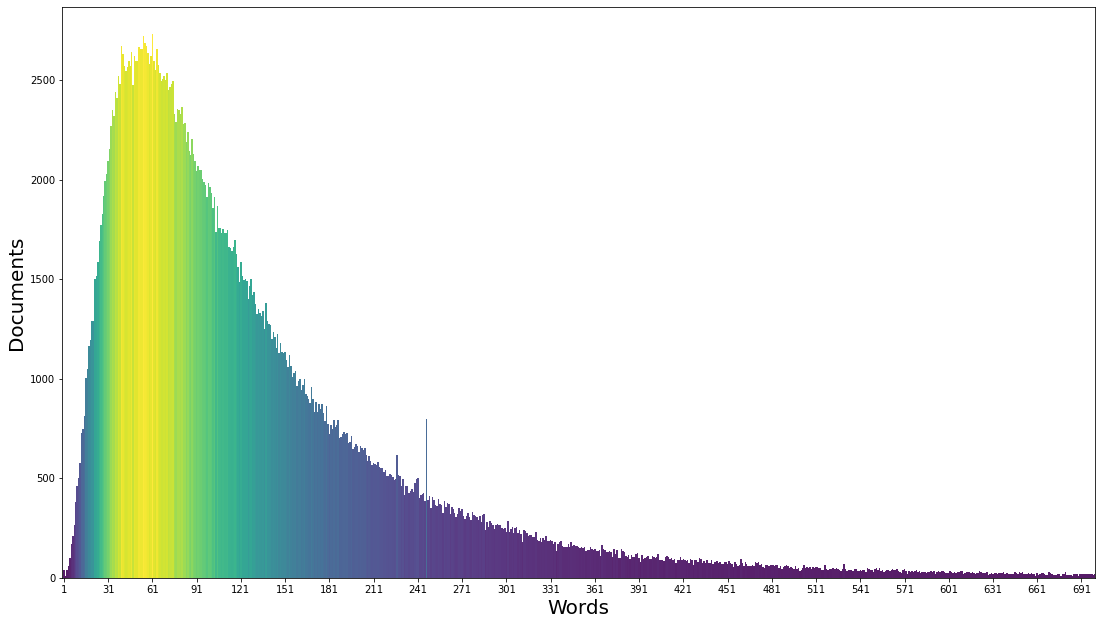

In [17]:
# построим по полученным данным нормализованную гистограмму
c = Counter(words_list)
keys = list(c.keys())
values = list(c.values())

#n, bins, patches = sns.histplot(x=keys, weights=values, discrete=True, , bins=90, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
n, bins, patches = plt.hist(x = keys, weights=values, bins=np.arange(len(keys))-0.5, facecolor='#2ab0ff', alpha=0.9)
n = n.astype('int')

for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))

#plt.style.use('seaborn-whitegrid')

plt.xticks(np.arange(min(keys), max(keys)+1, 30.0))
plt.xlim(0, 700)

plt.xlabel('Words', fontsize=20)
plt.ylabel('Documents', fontsize=20)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
#fig.savefig('test2png.png', dpi=100)

plt.show()

### Распределение количества предложений в каждом документе

In [18]:
# список количеств слов
sentences_list = []
# паттерн для деления на предложения, объяснение:(https://regex101.com/r/he9d1P/1)
# почти всегда делит правильно, в предлоежниях с именем и отчеством через точку ошибается на +1, что
# для выборки в 400к незначительно
pattern = re.compile('.*?(\.|\?|\!|…)(?= *[А-Я]|$)')

for message in tqdm(list_full_file_json):
    sentences_message = len(pattern.findall(message['text']))
    sentences_list.append(sentences_message)

100%|██████████| 386254/386254 [00:13<00:00, 29318.50it/s]


In [19]:
# посмотрим на самые частые количества предложений на одно сообщение
c = Counter(sentences_list).most_common(15)
c

[(1, 30858),
 (5, 27663),
 (6, 26935),
 (4, 26777),
 (7, 25319),
 (3, 24184),
 (8, 23094),
 (2, 20998),
 (9, 20631),
 (10, 18486),
 (11, 16236),
 (12, 14368),
 (13, 12303),
 (14, 10882),
 (15, 9619)]

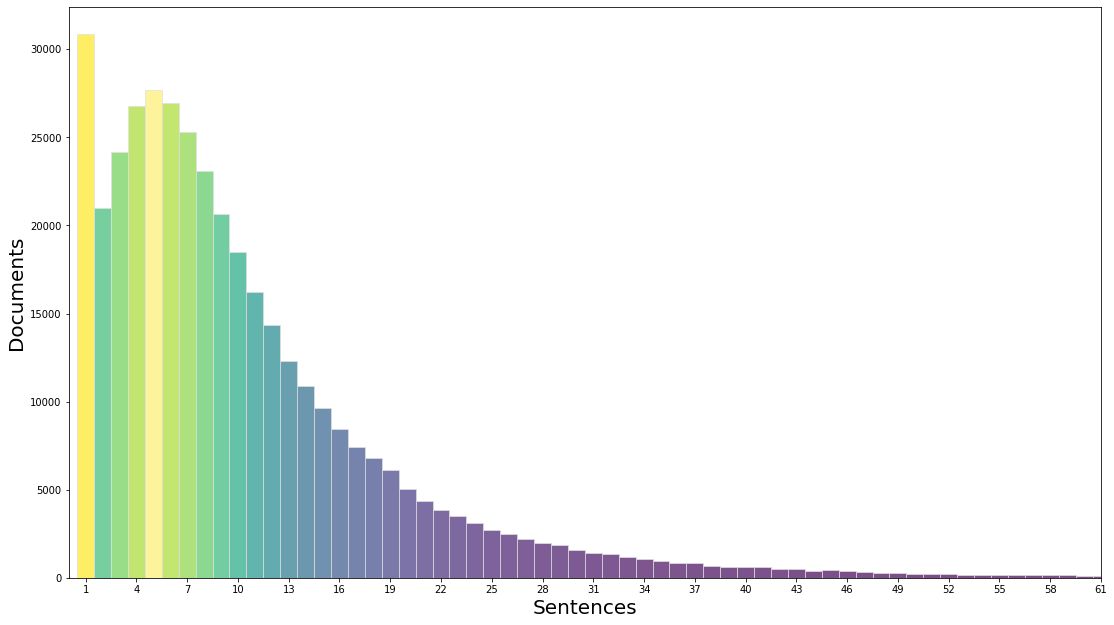

In [20]:
# построим по полученным данным нормализованную гистограмму
c = Counter(sentences_list)
keys = list(c.keys())
values = list(c.values())

#n, bins, patches = sns.histplot(x=keys, weights=values, discrete=True, , bins=90, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
n, bins, patches = plt.hist(x = keys, weights=values, bins=np.arange(len(keys))-0.5, facecolor='#2ab0ff', edgecolor='#e0e0e0', alpha=0.7)
n = n.astype('int')

for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))

#plt.style.use('seaborn-whitegrid')

plt.xticks(np.arange(min(keys), max(keys)+1, 3.0))
plt.xlim(0, 61)

patches[5].set_fc('#FDEE70') # Set color

plt.xlabel('Sentences', fontsize=20)
plt.ylabel('Documents', fontsize=20)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
#fig.savefig('test2png.png', dpi=100)

plt.show()

### Количество кореференциальных цепочек в каждом документе

In [21]:
# скрипт для приведения каждого размеченного для кореференции элемента к JSON виду
# для удобного обращения к параметрам
files_chain_list = []

for message in tqdm(list_full_file_json):
    list_coref_ent = message['annotation_sets']['']['annotations']
    message_chain_list = []
    
    for entity in list_coref_ent:
        entity = str(entity)[13:-1]  # адхок подрезка формата SH
        entity = ast.literal_eval(entity) # превращаю строку в виде дикта в дикт
        entity = json.dumps(entity) # делаем джсон из дикта
        message_chain_list.append(json.loads(entity)) # парсим джсон в список
        
    files_chain_list.append(message_chain_list) # в этом списке каждый файл идет отдельным списком-джсоном
    
    


100%|██████████| 386254/386254 [03:32<00:00, 1819.19it/s]


In [85]:
# теперь составим список, где каждый элемент будет представлять количество цепочек в документе
chain_amount_list = []

for json_item in tqdm(files_chain_list):
    chain_num_list = []
    
    for word in json_item:
        chain_num_list.append(word['antecedent_id'])
        
    # через каунтер приведем все к списку туплов и посчитаем количество туплов
    c = Counter(chain_num_list)
    chain_amount_list.append(len(c))

100%|██████████| 386254/386254 [00:09<00:00, 40910.10it/s]


In [23]:
c = Counter(chain_amount_list).most_common(15)
c

[(3, 72852),
 (2, 71844),
 (4, 58352),
 (1, 42884),
 (5, 42401),
 (6, 29204),
 (7, 19644),
 (8, 13345),
 (9, 9034),
 (10, 6379),
 (11, 4588),
 (12, 3284),
 (13, 2425),
 (14, 1853),
 (0, 1437)]

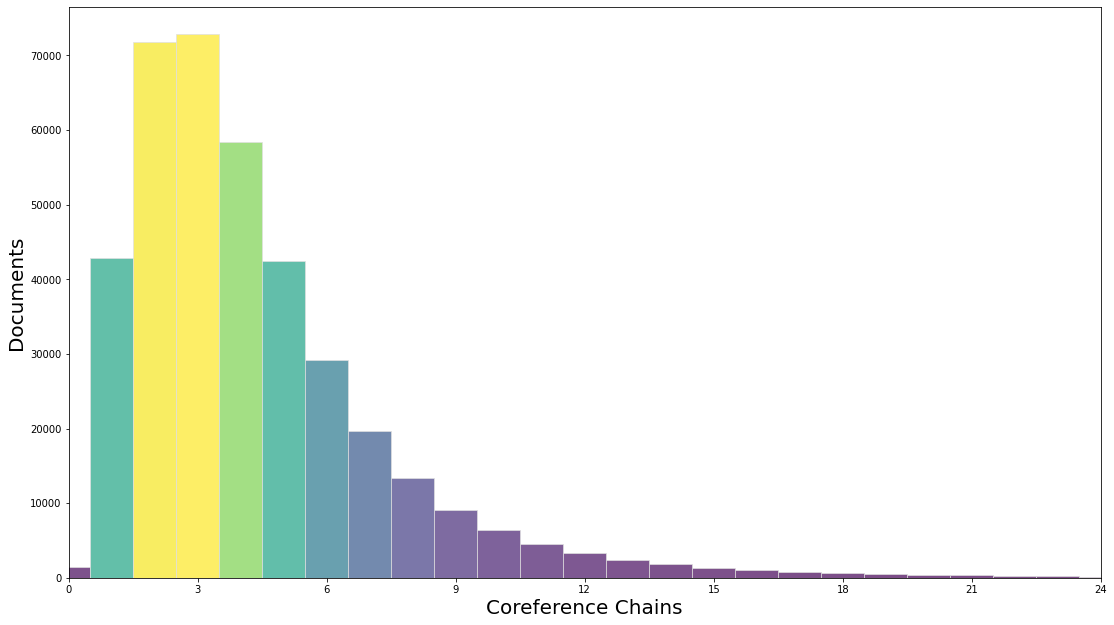

In [24]:
# построим по полученным данным нормализованную гистограмму
c = Counter(chain_amount_list)
keys = list(c.keys())
values = list(c.values())

#n, bins, patches = sns.histplot(x=keys, weights=values, discrete=True, , bins=90, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
n, bins, patches = plt.hist(x = keys, weights=values, bins=np.arange(len(keys))-0.5, facecolor='#2ab0ff', edgecolor='#e0e0e0', alpha=0.7)
n = n.astype('int')

for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))

#plt.style.use('seaborn-whitegrid')

plt.xticks(np.arange(min(keys), max(keys)+1, 3.0))
plt.xlim(0, 24)

plt.xlabel('Coreference Chains', fontsize=20)
plt.ylabel('Documents', fontsize=20)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
#fig.savefig('test2png.png', dpi=100)

plt.show()

### Распределение количества слов, выделенных, как значимые для кореференции. 

In [25]:
# сделаем список, каждый элемент которого - количество выделенных сущностей на файл
chain_entity_count_list = []

for chain_list in tqdm(files_chain_list):
    file_chain = len(chain_list)
    chain_entity_count_list.append(file_chain)

100%|██████████| 386254/386254 [00:00<00:00, 405286.70it/s]


In [26]:
# посмотрим на самые частые количества выделенных слов на одно сообщение
c = Counter(chain_entity_count_list).most_common(10)
c

[(3, 46122),
 (2, 44140),
 (4, 42001),
 (5, 36185),
 (6, 30509),
 (1, 27508),
 (7, 25025),
 (8, 21018),
 (9, 16878),
 (10, 13912)]

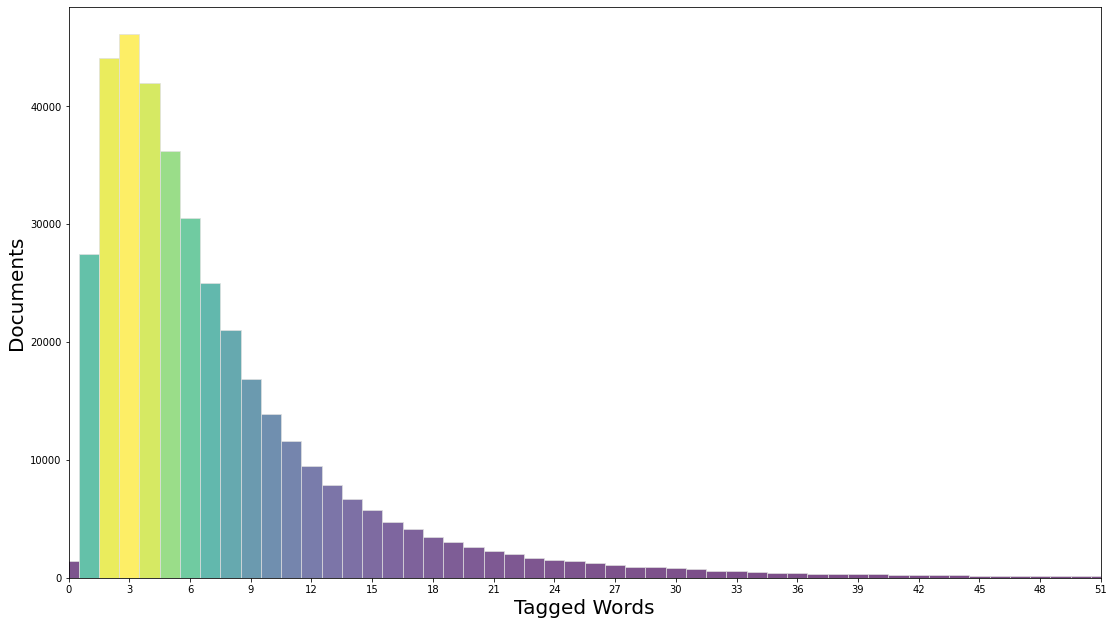

In [27]:
# построим по полученным данным нормализованную гистограмму
c = Counter(chain_entity_count_list)
keys = list(c.keys())
values = list(c.values())

#n, bins, patches = sns.histplot(x=keys, weights=values, discrete=True, , bins=90, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
n, bins, patches = plt.hist(x = keys, weights=values, bins=np.arange(len(keys))-0.5, facecolor='#2ab0ff', edgecolor='#e0e0e0', alpha=0.7)
n = n.astype('int')

for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))

#plt.style.use('seaborn-whitegrid')

plt.xticks(np.arange(min(keys), max(keys)+1, 3.0))
plt.xlim(0, 51)

plt.xlabel('Tagged Words', fontsize=20)
plt.ylabel('Documents', fontsize=20)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
#fig.savefig('test2png.png', dpi=100)

plt.show()

### Общее количество кореференциальных цепочек

In [28]:
# список количества цепочек в сообщении
c = Counter(chain_amount_list).most_common()
# счетчик цепочек
counter = 0

for pair in tqdm(c):
    counter += pair[0]*pair[1]
counter

100%|██████████| 64/64 [00:00<00:00, 292413.35it/s]


1693773

### Общее количество элементов в кореференциальных цепочках 

In [29]:
# список количества выделенных слов в сообщении
c = Counter(chain_entity_count_list).most_common()
# счетчик цепочек
counter = 0

for pair in tqdm(c):
    counter += pair[0]*pair[1]
counter

100%|██████████| 136/136 [00:00<00:00, 245028.07it/s]


2968033

### Отношение количества слов в сообщении к количеству цепочек

In [30]:
# количество слов по сообщениям уже есть
# количество цепочек по сообщениям уже есть
# осталось посчитать количество каждых возможных пар
word_chain_count_list = []
for word_count, chain_count in zip(words_list, chain_amount_list):
    word_chain_count_list.append((word_count, chain_count, ))
c = Counter(word_chain_count_list)
c

Counter({(16, 2): 404,
         (173, 2): 93,
         (177, 4): 149,
         (50, 2): 726,
         (127, 6): 134,
         (62, 4): 460,
         (92, 3): 457,
         (58, 2): 659,
         (249, 7): 40,
         (51, 3): 625,
         (83, 3): 531,
         (74, 1): 294,
         (227, 3): 200,
         (81, 8): 34,
         (52, 3): 634,
         (247, 2): 24,
         (77, 1): 254,
         (22, 2): 547,
         (249, 10): 26,
         (154, 6): 138,
         (61, 3): 656,
         (356, 9): 9,
         (116, 5): 255,
         (244, 3): 56,
         (116, 7): 103,
         (83, 1): 247,
         (74, 3): 582,
         (101, 5): 257,
         (80, 4): 419,
         (26, 1): 562,
         (116, 6): 165,
         (100, 6): 179,
         (102, 4): 359,
         (161, 2): 113,
         (64, 6): 159,
         (123, 6): 159,
         (131, 6): 161,
         (82, 6): 174,
         (242, 4): 53,
         (145, 2): 162,
         (74, 5): 271,
         (30, 3): 451,
         (124, 4): 28

In [31]:
ser = pd.Series(list(dict(c).values()), index=pd.MultiIndex.from_tuples(dict(c).keys()))
df = ser.unstack().fillna(0)
df.shape

(1007, 64)

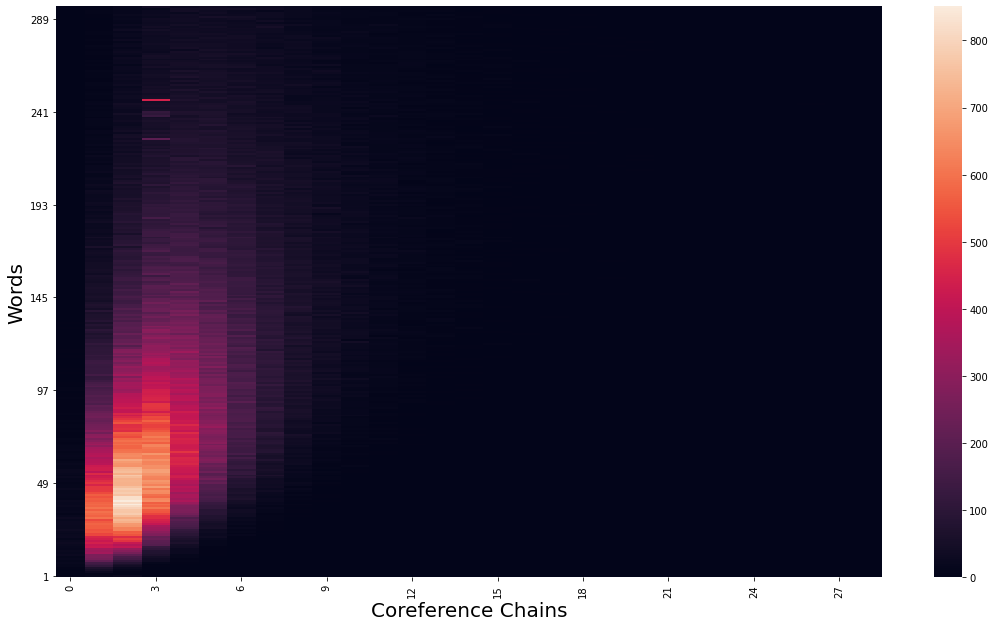

In [32]:
sns.heatmap(df)

plt.xlim(0, 29)
plt.ylim(0, 295)


plt.xlabel('Coreference Chains', fontsize=20)
plt.ylabel('Words', fontsize=20)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
#fig.savefig('test2png.png', dpi=100)

plt.show()

# Перевод данных в формат CoNLL

Имеющиеся переменные:
+ количество слов
+ количество предложений
+ количество кореференциальных цеопчек
+ количество выделенных слов
+ список джейсонов аннотаций
+ список полных джейсонов

In [33]:
words_list[:10]

[16, 173, 177, 50, 127, 62, 92, 58, 249, 51]

In [34]:
sentences_list[:10]

[1, 5, 3, 5, 10, 9, 15, 8, 23, 9]

In [35]:
files_chain_list[:1]

[[{'norm': 'ребенок',
   '_string': 'ребенок',
   '_id': 882,
   'antecedent_id': 882,
   'status': 'antecedent',
   'start': 518,
   'end': 525},
  {'norm': 'я',
   '_string': 'меня',
   '_id': 884,
   'antecedent_id': 916,
   'status': 'anaphor',
   'start': 547,
   'end': 551}]]

In [36]:
list_full_file_json[8]['text']

'Здравствуйте! Ребенку (мальчик) 7 лет. Находимся на стационарном лечении 3 с хвостиком недели с диагнозом гематогенный остеомиелит грудины. Сначала на груди образовалась болезненная припухлость. Вялость, усталость ,плохой аппетит, плохой сон (стонал ночью даже во сне). Врачом в нашем городе после осмотра и рентгена был направлен на консультацию в г. Ровно, где по срочному положили в стационар (12.09.07). На момент госпитализации у ребенка сохранялась температура от 37,3 до 38,4 в течение недели. На стационаре температура держалась еще 10-12 дней, сейчас в норме. После анализа крови, мочи и просмотра сделанного дома снимка в стационаре выполнен разрез до кости и поставили дренаж (резинка). Затем, в период с 26.09. по 30.09.07 дренаж не устанавливался. Повторно установлен 01.10.07. Посев гнойного содержимого не проводился, доктора мы спрашивали. Томографию в клинике не выполняли. Пропили курс (10 дней) Аксеф-250, сейчас назначен препарат рифампицин. Повторный рентген сделан 3 недели спу

In [229]:
conll_df = pd.DataFrame({'doc_name': [], 'zeros': [], 'word_num_sent': [], 'sent_entry': [], 'pos': [], 'star1': [], 'empty1': [], 'empty2': [],'empty3': [],'empty4': [],'empty5': [], 'star2': [], 'coref': [],})

conll_df.head()

,doc_name,zeros,word_num_sent,sent_entry,pos,star1,empty1,empty2,empty3,empty4,empty5,star2,coref


In [38]:
name_ptt = re.compile('[^/]+$') # а был же уже файл ну ладно и так можно....
sentence_ptt = re.compile('.*?(?:\.|\?|\!|…)(?= *[А-Я]|$)')

In [235]:
# создадим все нужные параметры, чтобы потом построчно записывать в датафрейм 
document_name = ''
sentences_list = []
names_list = []
for document in tqdm(list_full_file_json):
    
    # имя документа
    document_name = name_ptt.search(document['features']['path']).group(0) # nedug-ru_734132-0000.xml
    
    # предложения документа 
    document_sentences = sentence_ptt.findall(document['text'])
    sentences_list.append(document_sentences)
    names_list.append(document_name)
sentences_list[0][0]

100%|██████████| 386254/386254 [01:09<00:00, 5569.79it/s]


'Астигматизм это наследственное, лечиться только хирургически, ребенок неправильно видит, у меня такая же беда с рождения!'

In [200]:
sentences_list[0][0][0]

'З'

In [236]:
tagged_sentences_list = []
for sentences_document in tqdm(sentences_list):
    tagged_sentences_doc = []
    for sentence in sentences_document:
        # слова в предложениях + pos
        tokens = nltk.word_tokenize(sentence)
        tagged_sentences_doc.append(nltk.pos_tag(tokens, lang = 'rus'))
    tagged_sentences_list.append(tagged_sentences_doc)

100%|██████████| 386254/386254 [2:25:51<00:00, 44.14it/s]     


In [202]:
tagged_sentences_list[1] #[0]#[0]#[1]

[[('Здравствуйте', 'INTJ'), ('!', 'NONLEX')],
 [('Очень', 'ADV'),
  ('надеюсь', 'V'),
  ('получить', 'V'),
  ('здесь', 'ADV-PRO'),
  ('второе', 'ANUM=n'),
  ('мнение', 'S'),
  ('по', 'PR'),
  ('поводу', 'S'),
  ('здоровья', 'S'),
  ('своего', 'A-PRO=m'),
  ('сына', 'S'),
  ('.', 'NONLEX')],
 [('Ребенку', 'S'),
  ('2', 'NUM=ciph'),
  ('года', 'S'),
  ('7', 'NUM=ciph'),
  ('месяцев', 'S'),
  ('.', 'NONLEX')],
 [('Поставлены', 'V'),
  ('диагнозы', 'S'),
  (':', 'NONLEX'),
  ('анизометропия', 'S'),
  (',', 'NONLEX'),
  ('гиперметропия', 'S'),
  ('.', 'NONLEX'),
  ('OD', 'NONLEX'),
  ('+2,5', 'NONLEX'),
  (',', 'NONLEX'),
  ('OS', 'NONLEX'),
  ('+5,0', 'NONLEX'),
  ('.', 'NONLEX')],
 [('Рекомендованы', 'V'),
  ('очки', 'S'),
  ('для', 'PR'),
  ('постоянного', 'A=n'),
  ('ношения', 'S'),
  ('+0,5/+2,0', 'S'),
  ('.', 'NONLEX')],
 [('Явка', 'S'),
  ('через', 'PR'),
  ('2', 'NUM=ciph'),
  ('месяца', 'S'),
  ('.', 'NONLEX')],
 [('Вопросы', 'S'), (':', 'NONLEX'), ('1', 'NUM=ciph'), ('.', 'NONLEX

In [237]:
# осталось только сделать кореференцию
# получим список неочищенных файлов, чтобы обращаться к кореференциальным
# цепочкам по их положению в тексте,
# а не по написанию, таким образом ничего не перепутается

list_full_file_json_dirty = [] # список, в котором каждый элемент - содержимое одного файла

# цикл для прохода по всем файлам и сбора их содержимого
for filename in tqdm(list_of_files):
    # абсолютный путь к единичному файлу
    path_single = path + '/' + filename
    # открываем
    with open(path_single) as file:
        file = json.load(file)
        list_full_file_json_dirty.append(file)

100%|██████████| 386254/386254 [12:19<00:00, 522.35it/s]  


In [208]:
type(list_full_file_json_dirty[1]['annotation_sets']['']['annotations'])#[1]['features']['_string']

list

In [209]:
print(len(names_list), len(tagged_sentences_list), len(list_full_file_json_dirty))

2 2 2


In [238]:
# количество элементов во всех списках одинаковое, поэтому можно сделать zip, а не map
for filename, tagged_sentences_list_small, annotations_text in zip(names_list, tagged_sentences_list, list_full_file_json_dirty):
            
    # кореференция
    # отсюда буду получать номера начала и конца кореференциального участника
    annotations = annotations_text['annotation_sets']['']['annotations'].copy()
    # здесь буду искать по номерам начала и конца кусочек текста - на всякий случай
    text = annotations_text['text']
    # список, который станет строчками датафрейма
    list_of_rows = []
    
    for sentences in tagged_sentences_list_small:
        
        
        word_position_counter = 0
        
        for sentence in sentences:
            
            row = []
            
            
            #первый столбец имя файла
            row.append(filename)
            # строка нулей
            row.append(0)
            # номер слова
            row.append(word_position_counter)
            word_position_counter += 1
            # единица предложения
            row.append(sentence[0])
            # pos-tag для единицы
            row.append(sentence[1])
            # строка для дерева
            row.append('-')
            # строка 
            row.append('-')
            # строка 
            row.append('-')
            # строка 
            row.append('-')
            # строка 
            row.append('-')
            # строка 
            row.append('__')
            # строка 
            row.append('*')
            
            # реверс нужен для удаления
            for features_list in reversed(annotations):
                # проходим по списку фичерсов и смотрим: если совпадает sentence[0][0] со _string,
                #то добавляем слову кореф
                string_from_txt = features_list['features']['_string']
                
                if sentence[0] == string_from_txt:
                    row.append('(' + str(features_list['features']['antecedent_id']) + ')')
                    # удаляем использованный тег кореференции
                    annotations.remove(features_list)
                    break
            else:
                row.append('-')
            
            list_of_rows.append(row)
            
    conll_df = conll_df.append(pd.DataFrame(list_of_rows, columns=conll_df.columns))        
            


KeyboardInterrupt: 

In [233]:
#conll_df = conll_df.iloc[0:0] # лучше дропа 

In [273]:
conll_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11932678 entries, 0 to 310
Data columns (total 14 columns):
doc_name           object
zeros              float64
word_num_sent      float64
sent_entry         object
pos                object
star1              object
empty1             object
empty2             object
empty3             object
empty4             object
empty5             object
star2              object
coref              object
sentence_number    int64
dtypes: float64(2), int64(1), object(11)
memory usage: 1.3+ GB


In [247]:
def getSizeOfNestedList(listOfElem):
    ''' Get number of elements in a nested list'''
    count = 0
    # итерируем по списку
    for elem in listOfElem:
        # проверяем тип элемента
        if type(elem) == list:  
            # и ркекурсивно вызываем снова эту функцию для подсчета
            count += getSizeOfNestedList(elem)
        else:
            count += 1    
    return count

In [248]:
getSizeOfNestedList(tagged_sentences_list)

64851795

# Результаты 180 часов работы программы.
Было обработано и внесено в датафрейм 11 932 678 элементов из 64 851 795.

Осталось обработать 52 919 117 элементов

На настоящем этапе правильно будет остановиться на этом и выделить доступные компьютерные мощности на запуск следующих этапов пайплайна.

In [249]:
# нужна функция для добавления колонки номера предложения зфтвф
sentence_number_list = []
i = 0
for document in tqdm(tagged_sentences_list):
    for sentence in document:
        for word in sentence:
            sentence_number_list.append(i)
        i += 1

100%|██████████| 386254/386254 [01:05<00:00, 5930.58it/s]


In [251]:
len(sentence_number_list)

64851795

In [270]:
sentence_number_list_180h = sentence_number_list[:11932678]
len(sentence_number_list_180h)

11932678

In [271]:
len(conll_df)

11932678

In [272]:
conll_df['sentence_number'] = sentence_number_list_180h

In [277]:
conll_df['zeros'] = conll_df['zeros'].astype(np.int64)

In [279]:
conll_df['word_num_sent'] = conll_df['word_num_sent'].astype(np.int64)

In [280]:
conll_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11932678 entries, 0 to 310
Data columns (total 14 columns):
doc_name           object
zeros              int64
word_num_sent      int64
sent_entry         object
pos                object
star1              object
empty1             object
empty2             object
empty3             object
empty4             object
empty5             object
star2              object
coref              object
sentence_number    int64
dtypes: int64(3), object(11)
memory usage: 1.3+ GB


In [281]:
conll_df.head()

,doc_name,zeros,word_num_sent,sent_entry,pos,star1,empty1,empty2,empty3,empty4,empty5,star2,coref,sentence_number
0,babyblog-ru-communities_diseases-1696018-0001.xml,0,0,Астигматизм,S,-,-,-,-,-,-,*,-,0
1,babyblog-ru-communities_diseases-1696018-0001.xml,0,1,это,A-PRO=n,-,-,-,-,-,-,*,-,0
2,babyblog-ru-communities_diseases-1696018-0001.xml,0,2,наследственное,A=n,-,-,-,-,-,-,*,-,0
3,babyblog-ru-communities_diseases-1696018-0001.xml,0,3,",",NONLEX,-,-,-,-,-,-,*,-,0
4,babyblog-ru-communities_diseases-1696018-0001.xml,0,4,лечиться,V,-,-,-,-,-,-,*,-,0


In [ ]:
# заменить двойные кавычки и отредактировать тире на два нижних подчеркивания(__) и нонлекс на знак

### Заменить тире на два нижних подчеркивания (__)

In [290]:
def remean_points(cell):
    cell = "__"
    return cell

conll_df.empty5 = conll_df.empty5.apply(remean_points)
conll_df.head()

,doc_name,zeros,word_num_sent,sent_entry,pos,star1,empty1,empty2,empty3,empty4,empty5,star2,coref,sentence_number
0,babyblog-ru-communities_diseases-1696018-0001.xml,0,0,Астигматизм,S,-,-,-,-,-,__,*,-,0
1,babyblog-ru-communities_diseases-1696018-0001.xml,0,1,это,A-PRO=n,-,-,-,-,-,__,*,-,0
2,babyblog-ru-communities_diseases-1696018-0001.xml,0,2,наследственное,A=n,-,-,-,-,-,__,*,-,0
3,babyblog-ru-communities_diseases-1696018-0001.xml,0,3,",",NONLEX,-,-,-,-,-,__,*,-,0
4,babyblog-ru-communities_diseases-1696018-0001.xml,0,4,лечиться,V,-,-,-,-,-,__,*,-,0


Замена успешна

### Заменить двойные кавычки

In [300]:
changed_cells = []
def remean_points(cell):
    if str(cell) == '"':
        cell = "'"
        changed_cells.append(1)
    else:
        changed_cells.append(0)
    return cell

conll_df.sent_entry.apply(remean_points)

0         Астигматизм
1                 это
2      наследственное
3                   ,
4            лечиться
            ...      
306               еще
307               для
308        постановки
309          диагноза
310                 .
Name: sent_entry, Length: 11932678, dtype: object

In [301]:
len(changed_cells)
[i for i, e in enumerate(changed_cells) if e == 1]

[]

Двойных кавычек нет, можно будет спокойно удалять.

In [302]:
# правкой тегов имеет смысл заняться после получения результатов на имеющемся тегсете.

## Подготовка документа

In [303]:
conll_df['join'] = conll_df['doc_name'] + '          ' + conll_df['zeros'].astype(str) + '          ' + conll_df['word_num_sent'].astype(str) + '          ' + conll_df['sent_entry'] + '          ' + conll_df['pos'] + '          ' + conll_df['star1'] + '          ' + conll_df['empty1'] + '          ' + conll_df['empty2'] + '          ' + conll_df['empty3'] + '          ' + conll_df['empty4'] + ' ' + conll_df['empty5'] + '          ' + conll_df['star2'] + '          ' + conll_df['coref']




In [304]:
for i, g in tqdm(conll_df.groupby('sentence_number')['join']):
    out = g.append(pd.Series({'new':np.nan}))
    out.to_csv('diploma_data_12m.txt', index=False, header=None, mode='a')


Exception ignored in: <function tqdm.__del__ at 0x7fba6d99a4d0>
Traceback (most recent call last):
  File "/Users/egor/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py", line 1145, in __del__
    self.close()
  File "/Users/egor/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py", line 1274, in close
    if self.last_print_t < self.start_t + self.delay:
AttributeError: 'tqdm' object has no attribute 'last_print_t'
Exception ignored in: <function tqdm.__del__ at 0x7fba6d99a4d0>
Traceback (most recent call last):
  File "/Users/egor/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py", line 1145, in __del__
    self.close()
  File "/Users/egor/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py", line 1274, in close
    if self.last_print_t < self.start_t + self.delay:
AttributeError: 'tqdm' object has no attribute 'last_print_t'
Exception ignored in: <function tqdm.__del__ at 0x7fba6d99a4d0>
Traceback (most recent call last):
  File "/Users/egor/opt/anaconda3/lib/python3.7/s

In [ ]:
# удаление двойных кавычек + деление на файлы

### Деление на подгруппы для заданий берта

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)

In [11]:
!pwd

/Users/egor/Desktop/SemanticHub/diploma


К сожалению тетрадка упала, поэтому придется загрузить документ сначала.

In [13]:
path = 'diploma_data_12m.txt'
with open(path) as f:
    contents = f.readlines()
contents[:5]

['babyblog-ru-communities_diseases-1696018-0001.xml          0          0          Астигматизм          S          -          -          -          -          - __          *          -\n',
 'babyblog-ru-communities_diseases-1696018-0001.xml          0          1          это          A-PRO=n          -          -          -          -          - __          *          -\n',
 'babyblog-ru-communities_diseases-1696018-0001.xml          0          2          наследственное          A=n          -          -          -          -          - __          *          -\n',
 '"babyblog-ru-communities_diseases-1696018-0001.xml          0          3          ,          NONLEX          -          -          -          -          - __          *          -"\n',
 'babyblog-ru-communities_diseases-1696018-0001.xml          0          4          лечиться          V          -          -          -          -          - __          *          -\n']

In [14]:
len(contents)

12680956

In [23]:
# pattern = re.compile('\"')
for row in contents[:10]:
    row = re.sub('\"','', row)

In [27]:
contents[3]

'"babyblog-ru-communities_diseases-1696018-0001.xml          0          3          ,          NONLEX          -          -          -          -          - __          *          -"\n'

In [ ]:
col_names=['doc_name', 'zeros', 'word_num_sent', 'sent_entry', 'pos', 'star1', 'empty1', 'empty2', 'empty3', 'empty4', 'empty5', 'star2', 'coref']
conll_df = pd.read_csv('diploma_data_12m.txt',  sep='          ', engine='python', names=col_names)




In [ ]:
conll_df['join'] = conll_df['doc_name'] + '          ' + conll_df['zeros'].astype(str) + '          ' + conll_df['word_num_sent'].astype(str) + '          ' + conll_df['sent_entry'] + '          ' + conll_df['pos'] + '          ' + conll_df['star1'] + '          ' + conll_df['empty1'] + '          ' + conll_df['empty2'] + '          ' + conll_df['empty3'] + '          ' + conll_df['empty4'] + ' ' + conll_df['empty5'] + '          ' + conll_df['star2'] + '          ' + conll_df['coref']




In [ ]:
# пока поделим выборку просто по численным размерам 
df_train, df_test = train_test_split(conll_df, test_size=0.1, random_state=RANDOM_SEED, shuffle=False)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED, shuffle=False)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

TODO:
+ достать пол/дату из текста сообщений
+ узнать какая есть еще инфа про сообщения
+ убрать вхождения не важные для медицинского анализа
+ улучшить постеггирование, для знаков перпинания добавить собсвтенные символы, привести к универсальному формату
+ улучишть способ поиска расположения кореференции
+ Объединить в единое аббревиатуры
+ правильно очистить документы и расставить кореференцию только на нужные медицинские использования
+ улучшить качество выборки, чтобы не выделялось ничего в названиях и префиксах документов, отсеить такие вхождения(исполнено в конлл форматировании)
+ улучшить теггирование с помощью спейси https://pypi.org/project/spacy-conll/